### Problem Statement:

We have to predict whether a tumor is benign or malignant from the extracted features of cell nucleus images.

---

## Dataset description:

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

- Target attribute: Diagnosis (M = malignant, B = benign)

With the ten real-valued features computed for each cell nucleus:

- a) radius (mean of distances from center to points on the perimeter)
- b) texture (standard deviation of gray-scale values)
- c) perimeter
- d) area
- e) smoothness (local variation in radius lengths)
- f) compactness (perimeter^2 / area - 1.0)
- g) concavity (severity of concave portions of the contour)
- h) concave points (number of concave portions of the contour)
- i) symmetry
- j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features.

---


### Import Required Libraries

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost
import pickle

%matplotlib inline

### Data Explorations

In [2]:
# Read the csv file
df = pd.read_csv('data.csv')

# Display first 5 records
df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
# Display the shape of the dataset
print(f"Number of Features: {df.shape[-1]} \nNumber of Instances: {df.shape[0]}")

Number of Features: 33 
Number of Instances: 569


In [4]:
# Display dataset information (column names, data types, no. of non-null samples)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

### Insights:

- There is no null value for the given features.
- As the column "Unnamed" does not have any value as well as no context with the probelm, we should drop this from the datframe.

### Drop the unnecessary columns

In [5]:
df.drop(columns=['id', 'Unnamed: 32'], axis=0, inplace=True)
df.shape


(569, 31)

#### As the target attribute, "Diagnosis" is categorical in nature, lets convert each class of it into corresponding binary column using "One-Hot" encoding.

In [6]:
# Create the dummies from diagnosis column
diagnosis_dummies = pd.get_dummies(df['diagnosis'], prefix='diagnosis')

# Join the new column with the dataframe and drop the "Diagnosis" column
df = pd.concat([df.drop(columns='diagnosis', axis=1), diagnosis_dummies['diagnosis_M']], axis=1)

# Convert boolean value into binary value
df['diagnosis_M'] = df['diagnosis_M'].apply(lambda x: 1 if x else 0)

# rename the 'diagnosis_M' column
df.rename(columns={'diagnosis_M': 'malignant'}, inplace=True)

# Display the dataframe
df.head(5)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,malignant
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


### Visualize the target class distribution

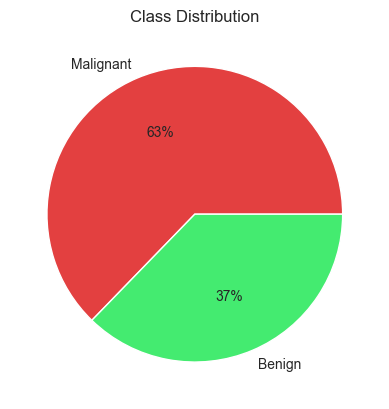

In [7]:
class_dict = df['malignant'].value_counts().to_dict()
plt.pie(list(class_dict.values()), labels=['Malignant', 'Benign'], colors=['#e34040', '#44eb70'], autopct='%.0f%%')
plt.title('Class Distribution')
plt.show()

### Check how each feature is correlated with malignancy

In [8]:
# Create a dataframe containing absolute correlation of every numerical features against the target
correlation_df = pd.DataFrame(df.corr().loc['malignant'])

# Drop the target attribute and rename the columns
correlation_df = correlation_df.drop('malignant')\
        .reset_index()\
        .rename(columns={'index':'Features', 'malignant':'Malignancy Correlation Value'})\
        .set_index('Features')

# Display the sorted dataframe with absolute correlation strength
display(
    correlation_df.sort_values(['Malignancy Correlation Value'], ascending=False)
    .style.background_gradient(cmap='YlGn')
)

,Malignancy Correlation Value
Features,
concave points_worst,0.793566
perimeter_worst,0.782914
concave points_mean,0.776614
radius_worst,0.776454
perimeter_mean,0.742636
area_worst,0.733825
radius_mean,0.730029
area_mean,0.708984
concavity_mean,0.696360


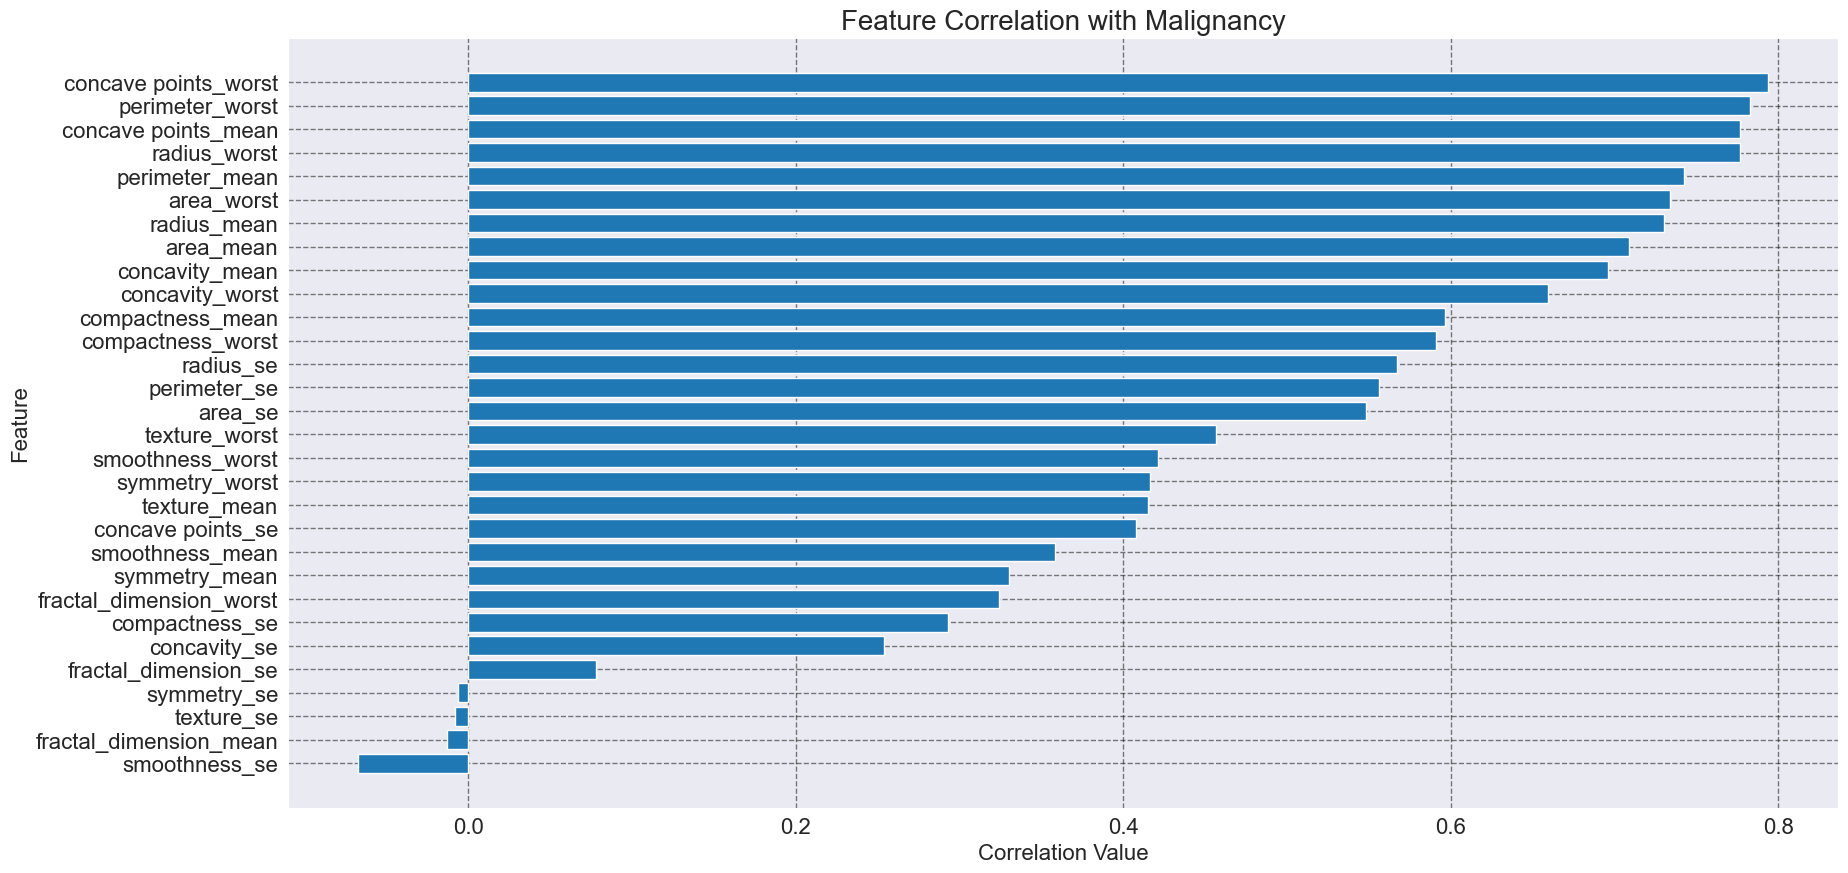

In [9]:
correlation_df.sort_values(['Malignancy Correlation Value'], inplace=True)
plt.figure(figsize=(20, 10))
plt.barh(correlation_df.index, correlation_df['Malignancy Correlation Value'])
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha=0.5)
plt.tick_params(labelsize=16)
plt.title('Feature Correlation with Malignancy', fontsize=20)
plt.xlabel('Correlation Value', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.show();


### Split the dataset into train and test

In [10]:
X = df.drop(columns='malignant', axis=1)
y = df['malignant']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Number of training samples: {len(X_train)} \nNumber of test samples: {len(X_test)}")

Number of training samples: 455 
Number of test samples: 114


### Scale the features

In [11]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

### Define all the models

In [12]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbor": KNeighborsClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "XG Boost": xgboost.XGBRFClassifier()
}

### Define the evaluation metrics

In [13]:
metrics = {
    "Accuracy": accuracy_score,
    "AUC Score": roc_auc_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score,
    "MCC Score": matthews_corrcoef
}

### Train the models

In [14]:
model_performance = {}
model_objects = {}
model_predictions = {}

for i, (model_name, model) in enumerate(models.items()):
    # Initialize the model evaluation dictionary
    model_evaluation = {}

    # Start training
    start_time = time.time()
    if model_name in ["Logistic Regression", "K-Nearest Neighbor"]:
        model.fit(X_train_sc, y_train)
        y_pred = model.predict(X_test_sc) # Make prediction
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test) # Make prediction
    end_time = time.time()

    # Calculate and populate the evaluation metrics
    for metric_name, metric in metrics.items():
        model_evaluation[metric_name] = "{:.4f}".format(metric(y_test, y_pred))

    model_performance[model_name] = model_evaluation
    model_predictions[model_name] = y_pred
    model_objects[model_name] = model

    print(f"Completed training in {end_time - start_time:.4f} seconds with {model_name} model")

Completed training in 0.0069 seconds with Logistic Regression model
Completed training in 0.0080 seconds with Decision Tree model
Completed training in 1.6003 seconds with K-Nearest Neighbor model
Completed training in 0.0022 seconds with Gaussian Naive Bayes model
Completed training in 0.1460 seconds with Random Forest model
Completed training in 0.1549 seconds with XG Boost model


### Model Performance

In [15]:
model_performance_df = pd.DataFrame.from_dict(model_performance, orient='index')

model_performance_df

,Accuracy,AUC Score,Precision,Recall,F1 Score,MCC Score
Logistic Regression,0.9737,0.9697,0.9762,0.9535,0.9647,0.9439
Decision Tree,0.9474,0.9440,0.9302,0.9302,0.9302,0.8880
K-Nearest Neighbor,0.9474,0.9440,0.9302,0.9302,0.9302,0.8880
Gaussian Naive Bayes,0.9737,0.9651,1.0000,0.9302,0.9639,0.9447
Random Forest,0.9649,0.9581,0.9756,0.9302,0.9524,0.9253
XG Boost,0.9561,0.9510,0.9524,0.9302,0.9412,0.9064


### Create Confusion matrix

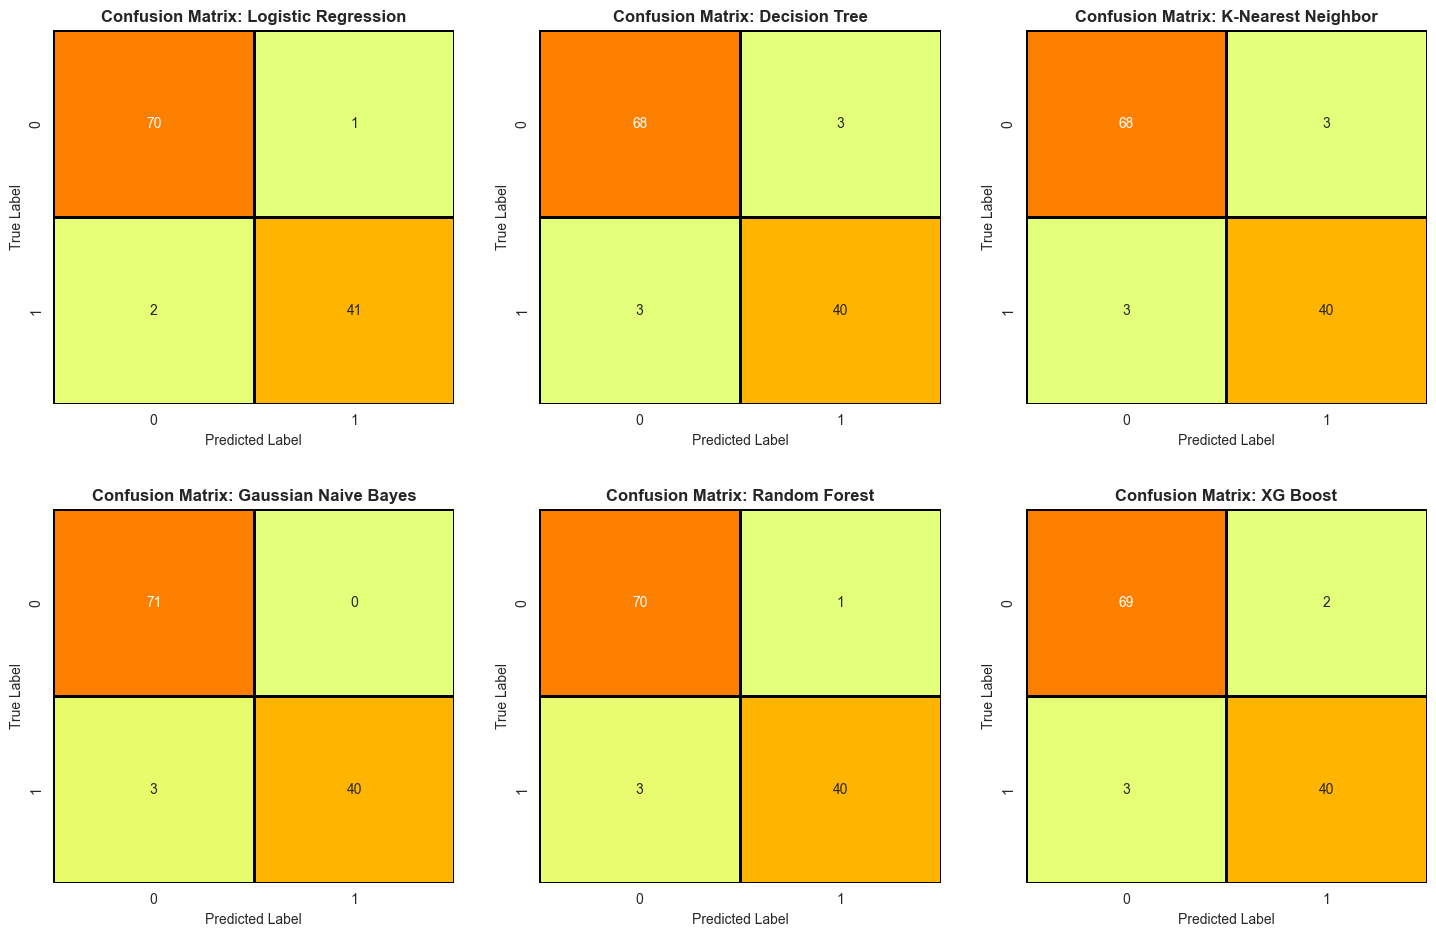

In [16]:
# Create a figure with a grid of subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (model_name, y_pred) in enumerate(model_predictions.items()):
    # Create confusion matrics
    cm = confusion_matrix(y_test, y_pred)

    # Plot using Seaborn heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Wistia', ax=axes[i], cbar=False, linewidths=1, linecolor='black')
    # Set titles and labels
    axes[i].set_title(f'Confusion Matrix: {model_name}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

# Adjust layout to prevent overlapping
plt.tight_layout(pad=3)
plt.show()


### Save the feature scaler & trained models

In [17]:
with open(f'model/scaler.pkl', 'wb') as file:
        pickle.dump(sc, file)
print("Successfully Saved Scaler")

for name, model in model_objects.items():
    with open(f'model/{name}.pkl', 'wb') as file:
        pickle.dump(model, file)
print("Successfully Saved all the trained Models")

Successfully Saved Scaler
Successfully Saved all the trained Models


### Create test csv file containing random 20 samples from the dataset

In [18]:
sampled_df = df.sample(n=20)
sampled_df.to_csv('test.csv', index=False)
print("Successfully Created Test Sampled Data")

Successfully Created Test Sampled Data
